In [409]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import accuracy_score # para a exibição da acurácia do modelo
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score # função para validação cruzada
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error


## Carregando Dados de treino e teste

In [410]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

## Modelo Random Forest


In [411]:
B_model = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=0)

# Transcrevendo dados não numéricos
O modelo Random Forest só trabalha com variáveis numéricas. Desse modo, ao analisarmos nosso dataset, fica evidente que necessitamos manipular a coluna datetime, a fim de transcrever as informações de data e hora em formato string para um formato numérico. Assim, o primeiro passo é dividir a coluna datetime em duas colunas filhas: date e time. Para tal, foram definidas as funções splitDate e splitTime.

In [412]:
def splitDate(value):
    return value.split(" ")[0]
def splitTime(value):
    return value.split(" ")[1]


train["date"] = train["datetime"].map(splitDate)
train["time"] = train["datetime"].map(splitTime)

test["date"] = test["datetime"].map(splitDate)
test["time"] = test["datetime"].map(splitTime)

train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,date,time
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011-01-01,00:00:00
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011-01-01,01:00:00
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011-01-01,02:00:00
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011-01-01,03:00:00
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011-01-01,04:00:00


Uma vez com os dados de data e hora separados, podemos extrair as informações individuais de dia, mês e ano

In [413]:
from datetime import datetime

def isWeekend(value):
    value = datetime.strptime(value, "%Y-%m-%d").strftime('%A')

    if value == "Sunday" or value == "Saturday":
        return 1
    else:
        return 0

def getWeekDay(value):
    value = datetime.strptime(value, "%Y-%m-%d").strftime('%A')

    if value == "Sunday":
        return 0
    elif value =="Monday":
        return 1
    elif value =="Tuesday":
        return 2
    elif value =="Wednesday":
        return 3
    elif value =="Thursday":
        return 4
    elif value =="Friday":
        return 5
    elif value == "Saturday":
        return 6

def getYear(value):
    value = int(datetime.strptime(value, "%Y-%m-%d").strftime('%Y'))
    return value

def getMonth(value):
    value = int(datetime.strptime(value, "%Y-%m-%d").strftime('%m'))
    return value

def getDay(value):
    value = int(datetime.strptime(value, "%Y-%m-%d").strftime('%d'))
    return value

def getQuarter(value):
    year = int(datetime.strptime(value, "%Y-%m-%d").strftime('%Y'))
    month = int(datetime.strptime(value, "%Y-%m-%d").strftime('%m'))

    if (year == 2011):
        return month
    else:
        return month + 12

dateFunctions = [getWeekDay, getYear, getMonth, getDay, isWeekend, getQuarter]
dateColumns = ["weekday", "year", "month", "day", "weekend", "quarter"]

for i in range(len(dateFunctions)):
    train[dateColumns[i]] = train["date"].map(dateFunctions[i])
    test[dateColumns[i]] = test["date"].map(dateFunctions[i])

train.drop('date', inplace=True, axis=1)
test.drop('date', inplace=True, axis=1)

train.head()


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,time,weekday,year,month,day,weekend,quarter
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,00:00:00,6,2011,1,1,1,1
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,01:00:00,6,2011,1,1,1,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,02:00:00,6,2011,1,1,1,1
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,03:00:00,6,2011,1,1,1,1
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,04:00:00,6,2011,1,1,1,1


De maneira análoga, extraíremos as informações mais relevantes referentes ao horário. Note que informações minuto e segundo são pouco impactantes para o treinamento do modelo. Em contrapartida, a informação de bicicletas alugadas durante as horas do dia pode ser bastante descritiva para o cenário em questão:

In [414]:
def getHour(value):
    value = int(datetime.strptime(value,  "%H:%M:%S").strftime('%H'))
    return value

    
train["hour"] = train["time"].map(getHour)
test["hour"] = test["time"].map(getHour)

train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,time,weekday,year,month,day,weekend,quarter,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,00:00:00,6,2011,1,1,1,1,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,01:00:00,6,2011,1,1,1,1,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,02:00:00,6,2011,1,1,1,1,2
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,03:00:00,6,2011,1,1,1,1,3
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,04:00:00,6,2011,1,1,1,1,4


# Analisando a distribuição de aluguél das bicicletas em função das variáveis temporais

## Bikes alugadas vs Hora

<AxesSubplot:xlabel='hour', ylabel='count'>

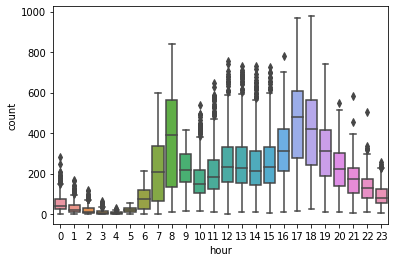

In [415]:
sns.boxplot(x = "hour",y="count",data=train)

## Bikes alugadas vs Dia

<AxesSubplot:xlabel='day', ylabel='count'>

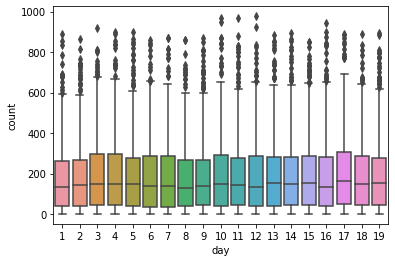

In [416]:
sns.boxplot(x = "day",y="count",data=train)

## Bikes alugadas vs Mês

<AxesSubplot:xlabel='month', ylabel='count'>

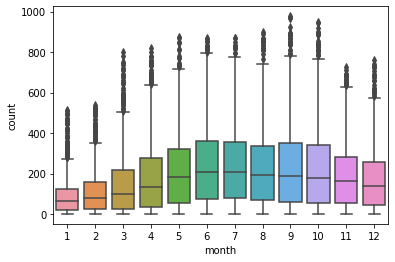

In [417]:
sns.boxplot(x = "month",y="count",data=train)

## Bikes alugadas vs Ano

<AxesSubplot:xlabel='year', ylabel='count'>

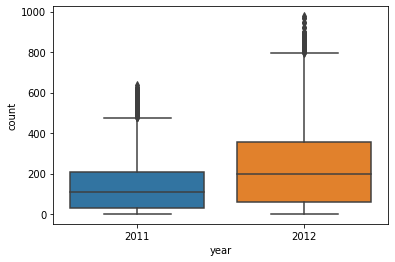

In [418]:
sns.boxplot(x = "year",y="count",data=train)

## Bikes alugadas vs Dia da semana

<AxesSubplot:xlabel='weekday', ylabel='count'>

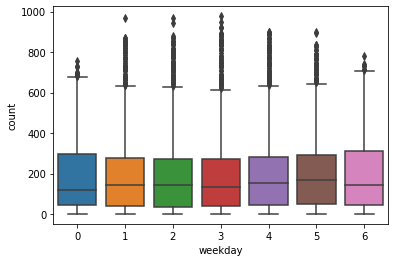

In [419]:
sns.boxplot(x = "weekday",y="count",data=train)

## Bikes alugadas vs Dia útil

<AxesSubplot:xlabel='workingday', ylabel='count'>

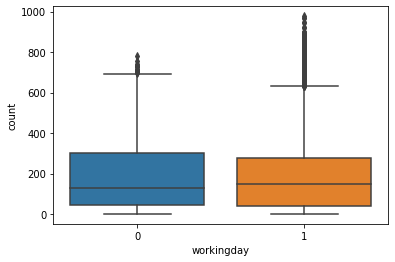

In [420]:
sns.boxplot(x = "workingday",y="count",data=train)

## Bikes alugadas vs Feriados

<AxesSubplot:xlabel='holiday', ylabel='count'>

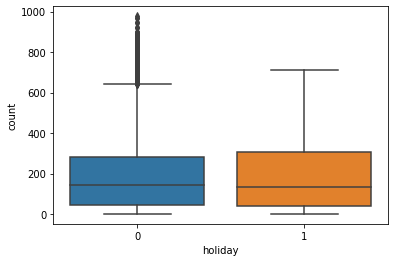

In [421]:
sns.boxplot(x = "holiday",y="count",data=train)

## Observações a partir das variáveis temporais
1. Aumento dos aluguéis de bikes no ano de 2012
2. Aluguel de bikes é maior em dias úteis do que em finais de semana
3. Aluguel de bikes é maior em períodos específicos do dia
4. Aluguel de bikes é menor nos feriados

# Analisando a distribuição de aluguél das bicicletas em função das variáveis climáticas

## Bikes alugadas vs Estação do Ano

<AxesSubplot:ylabel='count'>

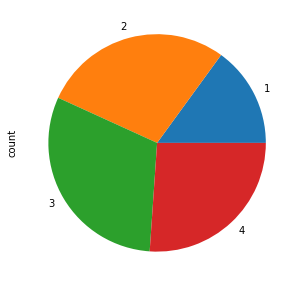

In [422]:
plt.figure(figsize=(5,5))
train.groupby(["season"])["count"].sum().plot.pie()

## Bikes alugadas vs Clima

<AxesSubplot:ylabel='count'>

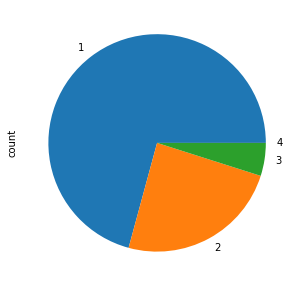

In [423]:
plt.figure(figsize=(5,5))
train.groupby(["weather"])["count"].sum().plot.pie()
# 1 = Limpo a nublado
# 2 = Tempo de Neblina
# 3 = Chuvas Leves
# 4 = Chuvas pesada / Neve

## Bikes alugadas vs Sensação térmica

<AxesSubplot:xlabel='atemp'>

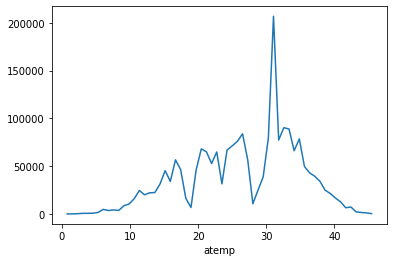

In [424]:
train.groupby("atemp")["count"].sum().plot()

## Observações a partir das variáveis climáticas
1. Aluguel de bikes é praticamente nulo em dias de chuvas pesadas / neve
2. Aluguel de bikes é claramente maior em dias com clima limpo e agradável
3. Aluguel de bikes é maior no verão e na primavera
4. Aluguel de bikes é maior quando a sensação térmica está em torno de 30°C

# Analisando a distribuição de aluguél de bikes por hora do dia para usuários registrados e usuários casuais

É natural esperar que usuários registrados tenham uma frequência mais bem definida que usuários casuais, uma vez que os assinantes tendem a usufruir das bikes durante os horários de ida e volta de trabalho/serviço, enquanto os casuais tendem a utilizar em momentos de lazer ou em ocasiões específicas. Com o objetivo de criar uma variável que encapsule períodos diferentes do dia, iremos antes avaliar a necessidade de gerar duas variáveis análogas, uma para os usuários cadastrados e outra pros usuários casuais

## Usuários Casuais vs Hora

<AxesSubplot:xlabel='hour', ylabel='casual'>

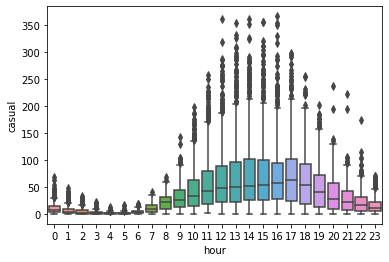

In [425]:
sns.boxplot(x = "hour",y="casual",data=train)

## Usuários Registrados vs Hora

<AxesSubplot:xlabel='hour', ylabel='registered'>

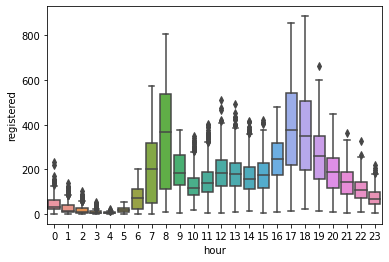

In [426]:
sns.boxplot(x = "hour",y="registered",data=train)

Assim, pode-se perceber que existe uma diferença significativa entre os horários de pico entre usuários casuais e usuários registrados. Dessa forma, como o esperado, usuários registrados usufruem do sistema de bikes em horários mais específicos do dia, muito provavelmente para se deslocarem na ida e na volta do horário comercial. Logo, é válido gerar uma varíavel que diferencie os momentos de pico de aluguéis de bike com base em que tipo de usuário estamos lidando

In [427]:
def getCasualDayPeriod(value):
    value = int(datetime.strptime(value,  "%H:%M:%S").strftime('%H'))

    if value <= 7 or value >= 22:       #perído entre 0-7h e 22-24h
        return 0
    elif value >= 11 and value <= 18:   #perído entre 11-18h
        return 1
    else:                               #perído entre 8-10h e 19-21h
        return 2

def getRegisteredDayPeriod(value):
    value = int(datetime.strptime(value,  "%H:%M:%S").strftime('%H'))

    if value <= 6 or value >= 20:       #perído entre 0-6h e 20-24h
        return 0
    elif value >= 10 and value <= 16:   #perído entre 10-16h
        return 1
    else:                               #perído entre 7-9h e 17-19h
        return 2

train["registeredPeriod"] = train["time"].map(getRegisteredDayPeriod)
test["registeredPeriod"] = test["time"].map(getRegisteredDayPeriod)
train["casualPeriod"] = train["time"].map(getCasualDayPeriod)
test["casualPeriod"] = test["time"].map(getCasualDayPeriod)

train.drop('time', inplace=True, axis=1)
test.drop('time', inplace=True, axis=1)

train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,...,count,weekday,year,month,day,weekend,quarter,hour,registeredPeriod,casualPeriod
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,...,16,6,2011,1,1,1,1,0,0,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,...,40,6,2011,1,1,1,1,1,0,0
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,...,32,6,2011,1,1,1,1,2,0,0
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,...,13,6,2011,1,1,1,1,3,0,0
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,...,1,6,2011,1,1,1,1,4,0,0


Podemos fazer algo similar para as temperaturas entre usuários casuais e registrados

<AxesSubplot:xlabel='temp'>

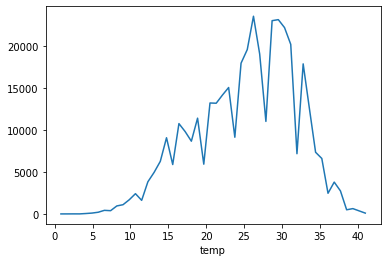

In [428]:
train.groupby("temp")["casual"].sum().plot()

<AxesSubplot:xlabel='temp'>

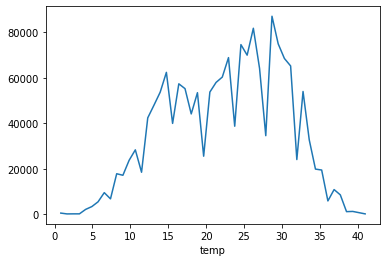

In [429]:
train.groupby("temp")["registered"].sum().plot()

In [430]:

def setCasualTemp():
    j = []
    models = [train, test]
    for type in models:
        j.clear()
        for i in type["temp"].iteritems() :
            if i[1] < 10 and i[1] >= 35:
                x = 0
                j.append(x)
            elif i[1] >= 20 and i[1] < 35:
                x = 1
                j.append(x)
            elif i[1] >= 10 and i[1] < 20:
                x = 2
                j.append(x)
            else:
                x = 3
                j.append(x)

        type["casualTemp"] = j

def setRegisteredTemp():
    j = []
    models = [train, test]
    for type in models:
        j.clear()
        for i in type["temp"].iteritems() :
            if i[1] < 7.5 and i[1] >=33:
                x = 0
                j.append(x)
            elif i[1] >= 7.5 and i[1] < 13:
                x = 1
                j.append(x)
            elif i[1] > 13 and i[1] < 33:
                x = 2
                j.append(x)
            else:
                x = 3
                j.append(x)
                
        type["registeredTemp"] = j
        
setRegisteredTemp()
setCasualTemp()
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,...,year,month,day,weekend,quarter,hour,registeredPeriod,casualPeriod,registeredTemp,casualTemp
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,...,2011,1,1,1,1,0,0,0,1,3
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,...,2011,1,1,1,1,1,0,0,1,3
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,...,2011,1,1,1,1,2,0,0,1,3
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,...,2011,1,1,1,1,3,0,0,1,3
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,...,2011,1,1,1,1,4,0,0,1,3


# Melhores Correlações:
 temp,atemp,faixa_temp
 season
 period, Hour, Month 

In [431]:
# treino_2 = train[["count","period","faixa_temp","hour","month"]]
# treino_2.head()

In [432]:
# treino_2.corr()

<AxesSubplot:xlabel='registeredPeriod', ylabel='count'>

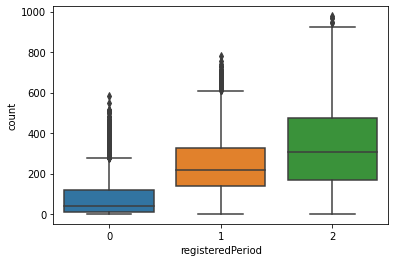

In [433]:
sns.boxplot(x = "registeredPeriod",y="count",data=train)

<AxesSubplot:xlabel='casualPeriod', ylabel='count'>

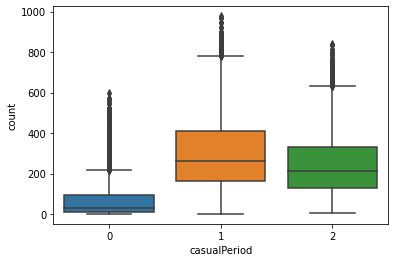

In [434]:
sns.boxplot(x = "casualPeriod",y="count",data=train)


In [435]:
# sns.boxplot(x = "faixa_temp",y="count",data=train)
# maior contagem conforme maior a temperatura

In [436]:
#["season","holiday","workingday","weather","temp","atemp","humidity","windspeed","count","weekend","period"]
features = [ "casualTemp", "registeredTemp", "registeredPeriod", "casualPeriod", "season", "hour", "month", "year", "quarter", "weekday", "weekend", "holiday", "workingday", "weather", "humidity"]

x_treino = train[features]
y_treino = train["count"]

x_teste = test[features]


In [437]:
P = B_model.fit(x_treino, y_treino)
prev = B_model.predict(x_teste)
prev

array([ 13.35      ,   5.14333333,   5.7       , ..., 177.00583333,
       116.37      ,  70.84      ])

In [438]:
from os.path import exists
import os
outputPath = "result_model.csv"

file_exists = exists(outputPath)
if file_exists:
    os.remove(outputPath)

sub = pd.Series(prev, index=test["datetime"], name="count")
sub.to_csv(outputPath, header=True)

# test.head()
# P = B_model.fit(x_treino,y_treino)
# previsao = B_model.predict(x_treino)

# print('Pontuacao com dados de Treinamento: ',cross_val_score(P,x_treino,y_treino,cv=2))

In [439]:
# LModel = LinearRegression()
# L = LModel.fit(X=x_treino,y=y_treino)

# print('Pontuacao com dados de Treinamento: ',cross_val_score(L,x_treino,y_treino,cv=2))

In [440]:
# # Outro modelo para testar
# B_model = SVC(gamma="auto")
# P = B_model.fit(x_treino,y_treino)
# previsao = B_model.predict(x_treino)

# print('Pontuacao com dados de Treinamento: ',cross_val_score(P,x_treino,y_treino,cv=2))